# Parte II - Indexação dos dados e entendimento do cálculo de relevância

Neste notebook iremos:
1. Criar um índice no Solr e Elasticsearch e indexar os dados de filmes do TMDB (https://www.themoviedb.org/) 
* Realizar uma pesquisa e entender o cálculo de relevância (chamado de explain no Lucene)
* Ajustar o índice para melhorar o cálculo de relevância

### Pré-requisitos:

Antes de executar este notebook, as engines de busca devem estar rodando:

* Para Solr: <b>solr start -e cloud</b>
* Para Elasticsearch: <b>elasticsearch</b>

O Solr deve estar rodando na porta 8983 e o Elastic na 9200 (são as portas default).

Este notebook foi testado com Solr 8.2.0 e Elasticsearch 7.6.2

# Inicialização

Definição de variáveis e funções genéricas que serão usadas ao longo do notebook.

In [5]:
#PARÂMETROS

#Máquina e porta (formato host:port)
SOLR_ADDR='localhost:8983'
ELASTIC_ADDR='localhost:9200'

In [3]:
import json
import requests
from datetime import datetime
headers = {'content-type': 'application/json;charset=UTF-8'}

def date_diff_in_seconds(dt2, dt1):
    timedelta = dt2 - dt1
    return timedelta.days * 24 * 3600 + timedelta.seconds

# Some utilities for flattening the explain into something a bit more
# readable. Pass Explain JSON, get something readable (ironically this is what Solr's default output is :-p)
def flatten(l):
    [item for sublist in l for item in sublist]

def simplerExplain(explainJson, depth=0):
    result = " " * (depth * 2) + "%s, %s\n" % (explainJson['value'], explainJson['description'])
    #print json.dumps(explainJson, indent=True)
    if 'details' in explainJson:
        for detail in explainJson['details']:
            result += simplerExplain(detail, depth=depth+1)
    return result

# 1. Criação do índice de filmes TMDB

## Criar índice e indexar

As chamadas abaixo recriarão o índice no Solr e no Elastic indexando todos os dados com detecção automática de schema.

Nome da base: <b>tmdb </b>

In [72]:
import pickle

#Retorna um dicionário do python com os dados dos filmes
def extract():
    return pickle.load(open("../Dados/movies.p","rb"))

In [73]:
#Cria um índice novo no Solr e reindexa os dados
def reindex_solr(movieDict={}, delete=True):
    if delete:
        resp = requests.get("http://" + SOLR_ADDR + "/solr/admin/collections?action=DELETE&name=tmdb")
        resp = requests.get("http://" + SOLR_ADDR + "/solr/admin/collections?action=CREATE&name=tmdb&numShards=1")
        print("solr building...", resp.status_code)
    
    movies = ""
    
    for id, movie in movieDict.items():
        movies += json.dumps(movie) + ","
    
    bulkMovies = "[" + movies + "]"

    print("solr indexing...")
    resp = requests.post("http://" + SOLR_ADDR + "/solr/tmdb/update/json/docs?commit=true", data=bulkMovies, headers=headers)
    print("solr indexing done.", resp.status_code)

In [74]:
#Cria um índice novo no Elastic e reindexa os dados
def reindex_elastic(analysisSettings={}, mappingSettings={}, movieDict={}):
    settings = { #A
        "settings": {
            "number_of_shards": 1, #B
            "index": {
                "analysis" : analysisSettings, #C
    }}}

    if mappingSettings:
        settings['mappings'] = mappingSettings #C

    resp = requests.delete("http://" + ELASTIC_ADDR + "/tmdb") #D
    resp = requests.put("http://" + ELASTIC_ADDR + "/tmdb", 
                        data=json.dumps(settings), headers=headers)

    print("elastic building...", resp.status_code)
    
    if resp.status_code != 200:
        print(resp.text)
    
    bulkMovies = ""
    
    for id, movie in movieDict.items(): 
        addCmd = {"index": {"_index": "tmdb", #E
                            #"_type": "movie",
                            "_id": movie['id']}}
        bulkMovies += json.dumps(addCmd) + "\n" + json.dumps(movie) + "\n"

    print("elastic indexing...")
    resp = requests.post("http://" + ELASTIC_ADDR + "/_bulk", data=bulkMovies, headers=headers)
    print("elastic indexing done.", resp.status_code)

In [75]:
movieDict = extract()

#Chama o método de reindexação indicado da engine com contagem de tempo
def reindex(engine, engine_method):
    start = datetime.now()
     
    engine_method(movieDict=movieDict)
    
    end = datetime.now()
    delta = date_diff_in_seconds(end, start)
    print('%s engine done! (took %d seconds)\n' % (engine, delta))

In [97]:
reindex('Elastic', reindex_elastic)
reindex('Solr', reindex_solr)

elastic building... 200
elastic indexing...
elastic indexing done. 200
Elastic engine done! (took 141 seconds)

solr building... 200
solr indexing...
solr indexing done. 200
Solr engine done! (took 131 seconds)



## Ver o índice criado

In [1]:
#Imprime informações do índice TMDB do Solr
def print_solr():
    resp = requests.get("http://" + SOLR_ADDR + "/solr/tmdb/schema")
    json_schema = json.loads(resp.text)['schema']
    
    print('Fields:')
    fields = json_schema['fields']
    print (json.dumps(fields, indent=2, sort_keys=True))
    
    print('\nField Type text_general:')
    field_types = json_schema['fieldTypes']
    text_general = next((item for item in field_types if item['name'] == 'text_general'), None)
    print (json.dumps(text_general, indent=2, sort_keys=True))

In [78]:
#Imprime informações do índice TMDB do Elastic
def print_elastic():
    resp = requests.get("http://" + ELASTIC_ADDR + "/tmdb")
    json_object = json.loads(resp.text)
    print (json.dumps(json_object, indent=2, sort_keys=True))

Apresenta os detalhes do índice criado no Elasticsearch. <b>Observem os nomes dos campos e os tipos.</b>

In [79]:
print('Elastic results:')
print_elastic()

Elastic results:
{
  "tmdb": {
    "aliases": {},
    "mappings": {
      "properties": {
        "adult": {
          "type": "boolean"
        },
        "backdrop_path": {
          "fields": {
            "keyword": {
              "ignore_above": 256,
              "type": "keyword"
            }
          },
          "type": "text"
        },
        "belongs_to_collection": {
          "properties": {
            "backdrop_path": {
              "fields": {
                "keyword": {
                  "ignore_above": 256,
                  "type": "keyword"
                }
              },
              "type": "text"
            },
            "id": {
              "type": "long"
            },
            "name": {
              "fields": {
                "keyword": {
                  "ignore_above": 256,
                  "type": "keyword"
                }
              },
              "type": "text"
            },
            "poster_path": {
              "fields":

Apresenta os detalhes do índice criado no Solr. <b>Observem os nomes dos campos e os tipos.</b>

In [6]:
print('Solr results:')
print_solr()

Solr results:
Fields:
[
  {
    "name": "_nest_path_",
    "type": "_nest_path_"
  },
  {
    "docValues": false,
    "indexed": true,
    "name": "_root_",
    "stored": false,
    "type": "string"
  },
  {
    "indexed": true,
    "multiValued": true,
    "name": "_text_",
    "stored": false,
    "type": "text_general"
  },
  {
    "indexed": false,
    "name": "_version_",
    "stored": false,
    "type": "plong"
  },
  {
    "name": "adult",
    "type": "booleans"
  },
  {
    "name": "backdrop_path",
    "type": "text_general"
  },
  {
    "name": "belongs_to_collection.backdrop_path",
    "type": "text_general"
  },
  {
    "name": "belongs_to_collection.id",
    "type": "plongs"
  },
  {
    "name": "belongs_to_collection.name",
    "type": "text_general"
  },
  {
    "name": "belongs_to_collection.poster_path",
    "type": "text_general"
  },
  {
    "name": "budget",
    "type": "plongs"
  },
  {
    "name": "cast.cast_id",
    "type": "plongs"
  },
  {
    "name": "cast.char

# 2. Pesquisa básica

Com o índice criado no modo default, vamos realizar uma pesquisa por um filme. Queremos encontrar o filme sobre <b>basquete com alienígenas</b>, mas não lembramos o nome. :)

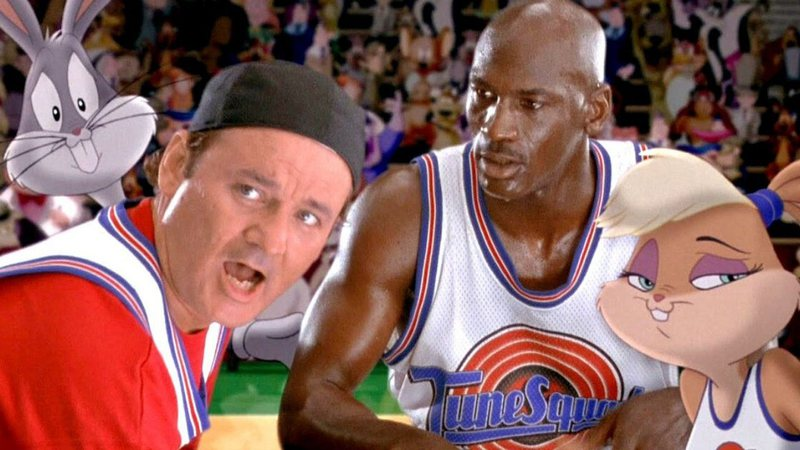

In [98]:
users_search = 'Basquete com alienígenas'
from IPython.display import Image
Image(filename='img/space_jam.jpg') 

A função abaixo faz a pesquisa especificada no Solr e imprime os resultados. 

Executa uma query centrada no termo com o uso do query parser <b>edismax</b>

In [99]:
#Faz a pesquisa especificada no Solr e imprime os resultados 
def search_solr(usersSearch, qf='title^10 overview', rows=30):
    url = 'http://' + SOLR_ADDR + '/solr/tmdb/select?q='+ usersSearch + '&defType=edismax&qf=' + qf + '&rows=' + str(rows) + '&wt=json&fl=title,score'
    httpResp = requests.get(url, headers=headers) #A
    searchHits = json.loads(httpResp.text)['response']['docs']
    print("Solr results")
    print("Num\tRelevance Score\t\tMovie Title") #B
    for idx, hit in enumerate(searchHits):
        print ("%s\t%s\t\t%s" % (idx + 1, hit['score'], hit['title']))
    print("\n")

Faz a pesquisa especificada no Elasticsearch e imprime os resultados

Executa uma query centrada no campo (multi_match) e query type best_fields (default)

Ver https://www.elastic.co/guide/en/elasticsearch/reference/current/query-dsl-multi-match-query.html

In [100]:
#Faz a pesquisa especificada no Elasticsearch e imprime os resultados
def search_elastic(usersSearch, query=None):
    if not query:
        query = {
            'query': {
                'multi_match': { 
                    'query': usersSearch, #A
                    'fields': ['title^10', 'overview'] #B
                }
            },
            'size': '50'
        }
    
    url = 'http://'+ ELASTIC_ADDR +'/tmdb/_search'
    httpResp = requests.get(url, data=json.dumps(query), headers=headers) #A
    searchHits = json.loads(httpResp.text)['hits']
    print("Elasticsearch results")
    print("Num\tRelevance Score\t\tMovie Title") #B
    for idx, hit in enumerate(searchHits['hits']):
            print ("%s\t%s\t\t%s" % (idx + 1, hit['_score'], hit['_source']['title']))
    print("\n")
    return query

In [101]:
query = search_elastic(users_search)

Elasticsearch results
Num	Relevance Score		Movie Title
1	89.936295		Monstros vs Alienígenas
2	53.835556		Com Amor, Simon
3	53.835556		Dança com Lobos
4	53.835556		Fale com Ela
5	53.835556		Brincando com Fogo
6	53.835556		Rebelde Com Causa
7	53.835556		Solteiros com Filhos
8	53.835556		Com Quem Será?
9	53.835556		Caminhando com Dinossauros
10	53.835556		Jogando com Prazer
11	53.835556		Amigas com Dinheiro
12	47.856194		Com Amor, Van Gogh
13	47.856194		O Tempo com Você
14	47.856194		Já Estou Com Saudades
15	47.856194		Entrevista Com o Vampiro
16	47.856194		(500) Dias com Ela
17	47.856194		Dois Loucos com Sorte
18	47.856194		Sete Dias com Marilyn
19	47.856194		Minha Vida com Liberace
20	47.856194		Dormindo com o Inimigo
21	47.856194		Aprendendo Com a Vovó
22	47.856194		Um Ladrão com Estilo
23	47.856194		Com a Bola Toda
24	47.856194		Com as Próprias Mãos
25	47.856194		Quero Ficar com Polly
26	47.856194		Para Roma com Amor
27	47.856194		Na Cama com Victoria
28	47.856194		Medo Ponto Com Br
2

In [103]:
search_solr(users_search, rows=50)

Solr results
Num	Relevance Score		Movie Title
1	38.96704		Invasão Alienígena
2	32.940956		Monstros vs Alienígenas
3	6.8350515		Space Jam - O Jogo do Século
4	3.66837		Estrada Para a Glória
5	3.230097		Bud, O Cão Amigo
6	3.1597097		Tio Drew
7	3.1555471		Forjando Campeões
8	3.1232567		Atração
9	3.119548		Diário de um Adolescente
10	3.119548		Homens Brancos Não Sabem Enterrar
11	3.020119		A Hora da Virada
12	2.9824467		A Reconquista
13	2.9196968		Olhos Famintos 2
14	2.8537858		Guerra dos Mundos
15	2.8001058		O Caminho de Volta
16	2.8001058		High School Musical
17	2.7957764		Experiência II - A Mutação
18	2.7717233		Jogada Decisiva
19	2.7717233		17 Outra Vez
20	2.6899261		Pequenos Grandes Astros
21	2.6582928		Trash - Náusea Total
22	2.6231563		Extinção
23	2.5593605		Distrito 9
24	2.5555978		Titan A.E.
25	2.5555978		Skyline - Além do Horizonte
26	2.5267746		Força Sinistra
27	2.5267746		Contatos de 4º Grau
28	2.4936817		Jogada Certa
29	2.4914322		Quase Abduzido
30	2.4914322		O Vôo do Navegado

Assim, o veredicto é:

In [93]:
from IPython.display import display, HTML

HTML('''<table>
        <tr><td><b>Solr 1 x 0 Elasticssearch</b></td></tr>
        <tr><td><img src="img/source.gif"></td></tr>
    </table>''')

Solr 1 x 0 Elasticssearch
""


## O que aconteceu? 

### Visualização da query lucene que a engine gerou

In [49]:
def explain_solr(users_search):
    url = 'http://' + SOLR_ADDR + '/solr/tmdb/select?q='+ users_search + '&debugQuery=true&defType=edismax&qf=title^10 overview&rows=1&wt=json&fl=title,score'
    httpResp = requests.get(url, headers=headers) #A
    explain = json.loads(httpResp.text)['debug']['parsedquery']
    print('Explicação da query no Solr:')
    print(explain)
    print('\n')

In [94]:
def explain_elastic(users_search):
    query = {
       'query': {
            'multi_match': { 
                'query': users_search,  #User's query
                'fields': ['title^10', 'overview']
            }
        }
    }
    httpResp = requests.get('http://'+ ELASTIC_ADDR +'/tmdb/_validate/query?explain',data=json.dumps(query), headers=headers)
    print('Explicação da query no Elasticsearch:')
    json_str= json.dumps(json.loads(httpResp.text), indent=2, ensure_ascii=False).encode('utf-8')
    print(json_str.decode())
    print('\n')

In [95]:
explain_elastic(users_search)
explain_solr(users_search)

Explicação da query no Elasticsearch:
{
  "_shards": {
    "total": 1,
    "successful": 1,
    "failed": 0
  },
  "valid": true,
  "explanations": [
    {
      "index": "tmdb",
      "valid": true,
      "explanation": "((overview:basquete overview:com overview:alienígenas) | (title:basquete title:com title:alienígenas)^10.0)"
    }
  ]
}


Explicação da query no Solr:
+(DisjunctionMaxQuery((overview:basquet | (title:basquet)^10.0)) DisjunctionMaxQuery((overview:alienigen | (title:alienigen)^10.0)))




### Debug da análise da query

Análise no Solr

In [96]:
resp = requests.get("http://" + SOLR_ADDR + "/solr/tmdb/analysis/field?analysis.fieldname=title&analysis.query=" + 
                    users_search +
                    "&analysis.showmatch=true&wt=json")

json_str= json.dumps(json.loads(resp.text), indent=2, ensure_ascii=False).encode('utf-8')
print(json_str.decode())

{
  "responseHeader": {
    "status": 0,
    "QTime": 1
  },
  "analysis": {
    "field_types": {},
    "field_names": {
      "title": {
        "query": [
          "org.apache.lucene.analysis.standard.StandardTokenizer",
          [
            {
              "text": "Basquete",
              "raw_bytes": "[42 61 73 71 75 65 74 65]",
              "start": 0,
              "end": 8,
              "org.apache.lucene.analysis.tokenattributes.PositionLengthAttribute#positionLength": 1,
              "type": "<ALPHANUM>",
              "org.apache.lucene.analysis.tokenattributes.TermFrequencyAttribute#termFrequency": 1,
              "position": 1,
              "positionHistory": [
                1
              ]
            },
            {
              "text": "com",
              "raw_bytes": "[63 6f 6d]",
              "start": 9,
              "end": 12,
              "org.apache.lucene.analysis.tokenattributes.PositionLengthAttribute#positionLength": 1,
              "type": 

Análise no Elasticsearch

In [53]:
import urllib.parse

data='{"field": "title", "text" : "'+ users_search + '"}'   
params = data.encode()

resp = requests.get('http://'+ ELASTIC_ADDR +'/tmdb/_analyze', data=params, headers=headers)

json_str= json.dumps(json.loads(resp.text), indent=2, ensure_ascii=False).encode('utf-8')
print(json_str.decode())

{
  "tokens": [
    {
      "token": "basquete",
      "start_offset": 0,
      "end_offset": 8,
      "type": "<ALPHANUM>",
      "position": 0
    },
    {
      "token": "com",
      "start_offset": 9,
      "end_offset": 12,
      "type": "<ALPHANUM>",
      "position": 1
    },
    {
      "token": "alienígenas",
      "start_offset": 13,
      "end_offset": 24,
      "type": "<ALPHANUM>",
      "position": 2
    }
  ]
}


# Entendendo o resultado

Agora vamos entender os cálculos de relevância das engines, lembrando que a similaridade utilizada no cálculo da relevância é baseada no BM25. 

A fórmula original do BM25, conforme descrita por Robertson e Zaragoza:

![title](img/bm25.png)

No entanto, há modificações da implementação desta fórmula no Lucene. A expressão (k+1) do numerador foi suprimida, com a justificativa de que essa constante não modifica o score resultante final. Mas há controvérsias e a diferença da supressão dessa constante pode ser observada [aqui](https://www.desmos.com/calculator/cklb27fcn9). O Solr utiliza da versão do BM25 conforme esta modificação. Já o Elasticsearch introduz uma constante na fórmula chamada de boost que nada mais é que o valor de (k + 1) multiplicado pelo boost definido para a cláusula.


Para saber mais, ver:

[Change request de modificação da fórmula BM25 no Lucene](https://issues.apache.org/jira/browse/LUCENE-8563)

[Simulação da fórmula do BM25](https://www.desmos.com/calculator/cklb27fcn9)


### Elasticsearch

"explanation": "((overview:basquete overview:com overview:alienígenas) | (title:basquete title:com title:alienígenas)^10.0)"

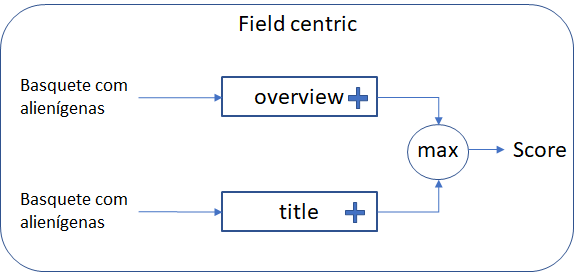

In [54]:
Image(filename='img/field_centric.png') 

In [38]:
query['explain'] = True
httpResp = requests.get('http://'+ ELASTIC_ADDR +'/tmdb/_search', data=json.dumps(query), headers=headers)
jsonResp = json.loads(httpResp.text)
print("Explain for %s" % jsonResp['hits']['hits'][0]['_source']['title'])
print(simplerExplain(jsonResp['hits']['hits'][0]['_explanation']))
print("Explain for %s" % jsonResp['hits']['hits'][1]['_source']['title'])
print(simplerExplain(jsonResp['hits']['hits'][1]['_explanation']))
print("Explain for %s" % jsonResp['hits']['hits'][2]['_source']['title'])
print(simplerExplain(jsonResp['hits']['hits'][2]['_explanation']))
print("Explain for %s" % jsonResp['hits']['hits'][3]['_source']['title'])
print(simplerExplain(jsonResp['hits']['hits'][3]['_explanation']))
print("Explain for %s" % jsonResp['hits']['hits'][25]['_source']['title'])
print(simplerExplain(jsonResp['hits']['hits'][25]['_explanation']))

Explain for Monstros vs Alienígenas
80.49949, max of:
  0.7777154, sum of:
    0.7777154, weight(overview:com in 718) [PerFieldSimilarity], result of:
      0.7777154, score(freq=3.0), computed as boost * idf * tf from:
        2.2, boost
        0.55221707, idf, computed as log(1 + (N - n + 0.5) / (n + 0.5)) from:
          1734, n, number of documents containing term
          3012, N, total number of documents with field
        0.6401595, tf, computed as freq / (freq + k1 * (1 - b + b * dl / avgdl)) from:
          3.0, freq, occurrences of term within document
          1.2, k1, term saturation parameter
          0.75, b, length normalization parameter
          120.0, dl, length of field (approximate)
          77.90339, avgdl, average length of field
  80.49949, sum of:
    80.49949, weight(title:alienígenas in 718) [PerFieldSimilarity], result of:
      80.49949, score(freq=1.0), computed as boost * idf * tf from:
        22.0, boost
        7.6161194, idf, computed as log(1 +

### Solr

+(DisjunctionMaxQuery((overview:basquete | (title:basquete)^10.0)) DisjunctionMaxQuery((overview:com | (title:com)^10.0)) DisjunctionMaxQuery((overview:alienígenas | (title:alienígenas)^10.0)))

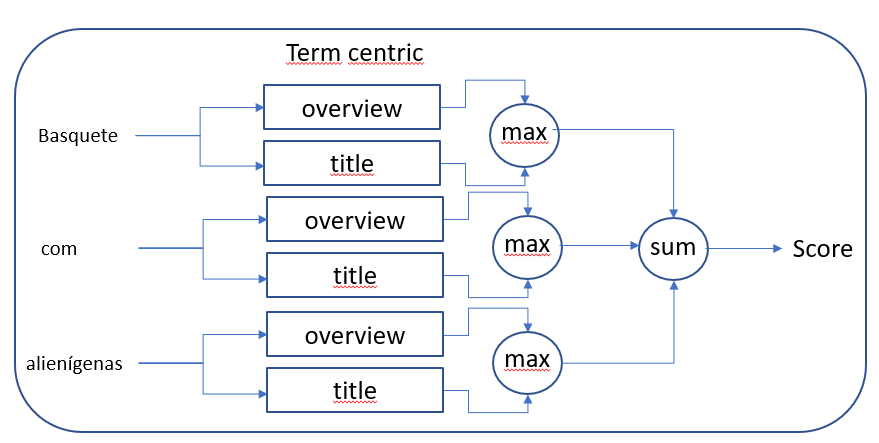

In [104]:
Image(filename='img/term_centric2.png') 

In [105]:
url = 'http://' + SOLR_ADDR + '/solr/tmdb/select?q='+ users_search + '&debug=True&defType=edismax&qf=title^10 overview&rows=30&wt=json&fl=id,title,score'
httpResp = requests.get(url, headers=headers)
docs = json.loads(httpResp.text)['response']['docs']
debug = json.loads(httpResp.text)['debug']['explain']
print("Explain for %s" % docs[0]['title'])
print(debug[docs[0]['id']])
print("Explain for %s" % docs[1]['title'])
print(debug[docs[1]['id']])
print("Explain for %s" % docs[2]['title'])
print(debug[docs[2]['id']])
print("Explain for %s" % docs[3]['title'])
print(debug[docs[3]['id']])
print("Explain for %s" % docs[25]['title'])
print(debug[docs[25]['id']])

Explain for Invasão Alienígena

38.96704 = sum of:
  38.96704 = max of:
    38.96704 = weight(title:alienigen in 7347) [SchemaSimilarity], result of:
      38.96704 = score(freq=1.0), product of:
        10.0 = boost
        7.9884753 = idf, computed as log(1 + (N - n + 0.5) / (n + 0.5)) from:
          2 = n, number of documents containing term
          7366 = N, total number of documents with field
        0.48779073 = tf, computed as freq / (freq + k1 * (1 - b + b * dl / avgdl)) from:
          1.0 = freq, occurrences of term within document
          1.2 = k1, term saturation parameter
          0.75 = b, length normalization parameter
          2.0 = dl, length of field
          2.3998098 = avgdl, average length of field

Explain for Monstros vs Alienígenas

32.940956 = sum of:
  32.940956 = max of:
    1.4009829 = weight(overview:alienigen in 5125) [SchemaSimilarity], result of:
      1.4009829 = score(freq=1.0), product of:
        4.1844215 = idf, computed as log(1 + (N - n +

# 3. Melhorando os resultados

Vamos modificar a análise para melhorar os resultados.

### Elasticsearch

Vamos alterar o analisador para o analyser <b>portuguese</b>.<p>
(https://www.elastic.co/guide/en/elasticsearch/reference/current/analysis-lang-analyzer.html#portuguese-analyzer)

Este analisador vem com o elasticsearch e o pipeline dele é:
* "lowercase"
* "portuguese_stop"
* "portuguese_keywords"
* "portuguese_stemmer"

In [106]:
mappingSettings = {
       'properties': {
               'title': { #A
                   'type': 'text',
                   'analyzer': 'portuguese'
               },
                'overview': {
                   'type': 'text',
                   'analyzer': 'portuguese'
               }
        }
}
reindex_elastic(mappingSettings=mappingSettings, movieDict=movieDict)

elastic building... 200
elastic indexing...
elastic indexing done. 200


Verificando o resultado da análise após a alteração

In [107]:
import urllib.parse

data='{"field": "title", "text" : "'+ users_search + '", "explain" : true}'   
params = data.encode()

resp = requests.get('http://'+ ELASTIC_ADDR +'/tmdb/_analyze', data=params, headers=headers)

json_str= json.dumps(json.loads(resp.text), indent=2, ensure_ascii=False).encode('utf-8')
print(json_str.decode())

{
  "detail": {
    "custom_analyzer": false,
    "analyzer": {
      "name": "portuguese",
      "tokens": [
        {
          "token": "basquet",
          "start_offset": 0,
          "end_offset": 8,
          "type": "<ALPHANUM>",
          "position": 0,
          "bytes": "[62 61 73 71 75 65 74]",
          "keyword": false,
          "positionLength": 1,
          "termFrequency": 1
        },
        {
          "token": "alienigen",
          "start_offset": 13,
          "end_offset": 24,
          "type": "<ALPHANUM>",
          "position": 2,
          "bytes": "[61 6c 69 65 6e 69 67 65 6e]",
          "keyword": false,
          "positionLength": 1,
          "termFrequency": 1
        }
      ]
    }
  }
}


Vamos repetir a pesquisa

In [108]:
print(users_search)
query = search_elastic(users_search)

Basquete com alienígenas
Elasticsearch results
Num	Relevance Score		Movie Title
1	85.72749		Invasão Alienígena
2	72.4701		Monstros vs Alienígenas
3	15.037114		Space Jam - O Jogo do Século
4	8.070415		Estrada Para a Glória
5	7.1062136		Bud, O Cão Amigo
6	6.9513617		Tio Drew
7	6.9422045		Forjando Campeões
8	6.871165		Atração
9	6.8630056		Diário de um Adolescente
10	6.8630056		Homens Brancos Não Sabem Enterrar
11	6.6442614		A Hora da Virada
12	6.5613832		A Reconquista
13	6.4233327		Olhos Famintos 2
14	6.2783284		Guerra dos Mundos
15	6.1602325		O Caminho de Volta
16	6.1602325		High School Musical
17	6.150708		Experiência II - A Mutação
18	6.0977917		Jogada Decisiva
19	6.0977917		17 Outra Vez
20	5.9178376		Pequenos Grandes Astros
21	5.848244		Trash - Náusea Total
22	5.7709436		Extinção
23	5.6305933		Distrito 9
24	5.6223154		Titan A.E.
25	5.6223154		Skyline - Além do Horizonte
26	5.5589046		Força Sinistra
27	5.5589046		Contatos de 4º Grau
28	5.4860997		Jogada Certa
29	5.481151		Quase Abduzid

Vamos agora ver a explicação do cálculo

In [109]:
query['explain'] = True
httpResp = requests.get('http://'+ ELASTIC_ADDR +'/tmdb/_search', data=json.dumps(query), headers=headers)
jsonResp = json.loads(httpResp.text)
print("Explain for %s" % jsonResp['hits']['hits'][0]['_source']['title'])
print(simplerExplain(jsonResp['hits']['hits'][0]['_explanation']))
print("Explain for %s" % jsonResp['hits']['hits'][1]['_source']['title'])
print(simplerExplain(jsonResp['hits']['hits'][1]['_explanation']))
print("Explain for %s" % jsonResp['hits']['hits'][2]['_source']['title'])
print(simplerExplain(jsonResp['hits']['hits'][2]['_explanation']))
print("Explain for %s" % jsonResp['hits']['hits'][3]['_source']['title'])
print(simplerExplain(jsonResp['hits']['hits'][3]['_explanation']))
print("Explain for %s" % jsonResp['hits']['hits'][25]['_source']['title'])
print(simplerExplain(jsonResp['hits']['hits'][25]['_explanation']))

Explain for Invasão Alienígena
85.72749, max of:
  85.72749, sum of:
    85.72749, weight(title:alienigen in 1256) [PerFieldSimilarity], result of:
      85.72749, score(freq=1.0), computed as boost * idf * tf from:
        22.0, boost
        7.9884753, idf, computed as log(1 + (N - n + 0.5) / (n + 0.5)) from:
          2, n, number of documents containing term
          7366, N, total number of documents with field
        0.4877907, tf, computed as freq / (freq + k1 * (1 - b + b * dl / avgdl)) from:
          1.0, freq, occurrences of term within document
          1.2, k1, term saturation parameter
          0.75, b, length normalization parameter
          2.0, dl, length of field
          2.3998098, avgdl, average length of field

Explain for Monstros vs Alienígenas
72.4701, max of:
  3.0821624, sum of:
    3.0821624, weight(overview:alienigen in 5125) [PerFieldSimilarity], result of:
      3.0821624, score(freq=1.0), computed as boost * idf * tf from:
        2.2, boost
       

### Solr

Vamos alterar o analisador para o analyser <b>text_pt</b>.<p>

<b>Não vamos confundir o text_pt default do Solr com o text_pt utilizado na busca!</b>

O text_pt default do Solr tem o seguinte pipeline:
 
* tokenizer class="solr.StandardTokenizerFactory"
* filter class="solr.LowerCaseFilterFactory"
* filter class="solr.StopFilterFactory" format="snowball" words="lang/stopwords_pt.txt" ignoreCase="true"
* filter class="solr.PortugueseLightStemFilterFactory"

In [110]:
url = 'http://' + SOLR_ADDR + '/solr/tmdb/schema'
data = '{"replace-field":{"name":"title","type":"text_pt","stored":true }}'
httpResp = requests.post(url, data=data,headers=headers)
print(httpResp.text)
data = '{"replace-field":{"name":"overview","type":"text_pt","stored":true }}'
httpResp = requests.post(url, data=data,headers=headers)
print(httpResp.text)

{
  "responseHeader":{
    "status":0,
    "QTime":742}}

{
  "responseHeader":{
    "status":0,
    "QTime":1500}}



In [64]:
reindex_solr(movieDict=movieDict, delete=False)

solr indexing...
solr indexing done. 200


Verificando o resultado da análise após a alteração

In [111]:
resp = requests.get("http://" + SOLR_ADDR + "/solr/tmdb/analysis/field?analysis.fieldname=title&analysis.query=" + 
                    users_search +
                    "&analysis.showmatch=true&wt=json")

json_str= json.dumps(json.loads(resp.text), indent=2, ensure_ascii=False).encode('utf-8')
print(json_str.decode())
explain_solr(users_search)

{
  "responseHeader": {
    "status": 0,
    "QTime": 13
  },
  "analysis": {
    "field_types": {},
    "field_names": {
      "title": {
        "query": [
          "org.apache.lucene.analysis.standard.StandardTokenizer",
          [
            {
              "text": "Basquete",
              "raw_bytes": "[42 61 73 71 75 65 74 65]",
              "start": 0,
              "end": 8,
              "org.apache.lucene.analysis.tokenattributes.PositionLengthAttribute#positionLength": 1,
              "type": "<ALPHANUM>",
              "org.apache.lucene.analysis.tokenattributes.TermFrequencyAttribute#termFrequency": 1,
              "position": 1,
              "positionHistory": [
                1
              ]
            },
            {
              "text": "com",
              "raw_bytes": "[63 6f 6d]",
              "start": 9,
              "end": 12,
              "org.apache.lucene.analysis.tokenattributes.PositionLengthAttribute#positionLength": 1,
              "type":

Vamos repetir a pesquisa

In [112]:
print(users_search)
search_solr(users_search)

Basquete com alienígenas
Solr results
Num	Relevance Score		Movie Title
1	38.96704		Invasão Alienígena
2	32.940956		Monstros vs Alienígenas
3	6.8350515		Space Jam - O Jogo do Século
4	3.66837		Estrada Para a Glória
5	3.230097		Bud, O Cão Amigo
6	3.1597097		Tio Drew
7	3.1555471		Forjando Campeões
8	3.1232567		Atração
9	3.119548		Diário de um Adolescente
10	3.119548		Homens Brancos Não Sabem Enterrar
11	3.020119		A Hora da Virada
12	2.9824467		A Reconquista
13	2.9196968		Olhos Famintos 2
14	2.8537858		Guerra dos Mundos
15	2.8001058		O Caminho de Volta
16	2.8001058		High School Musical
17	2.7957764		Experiência II - A Mutação
18	2.7717233		Jogada Decisiva
19	2.7717233		17 Outra Vez
20	2.6899261		Pequenos Grandes Astros
21	2.6582928		Trash - Náusea Total
22	2.6231563		Extinção
23	2.5593605		Distrito 9
24	2.5555978		Titan A.E.
25	2.5555978		Skyline - Além do Horizonte
26	2.5267746		Força Sinistra
27	2.5267746		Contatos de 4º Grau
28	2.4936817		Jogada Certa
29	2.4914322		Quase Abduzido
30	2.4

In [113]:
url = 'http://' + SOLR_ADDR + '/solr/tmdb/select?q='+ users_search + '&debug=True&defType=edismax&qf=title^10 overview&rows=30&wt=json&fl=id,title,score'
httpResp = requests.get(url, headers=headers)
docs = json.loads(httpResp.text)['response']['docs']
debug = json.loads(httpResp.text)['debug']['explain']
print("Explain for %s" % docs[0]['title'])
print(debug[docs[0]['id']])
print("Explain for %s" % docs[1]['title'])
print(debug[docs[1]['id']])
print("Explain for %s" % docs[2]['title'])
print(debug[docs[2]['id']])
print("Explain for %s" % docs[3]['title'])
print(debug[docs[3]['id']])
print("Explain for %s" % docs[25]['title'])
print(debug[docs[25]['id']])

Explain for Invasão Alienígena

38.96704 = sum of:
  38.96704 = max of:
    38.96704 = weight(title:alienigen in 7347) [SchemaSimilarity], result of:
      38.96704 = score(freq=1.0), product of:
        10.0 = boost
        7.9884753 = idf, computed as log(1 + (N - n + 0.5) / (n + 0.5)) from:
          2 = n, number of documents containing term
          7366 = N, total number of documents with field
        0.48779073 = tf, computed as freq / (freq + k1 * (1 - b + b * dl / avgdl)) from:
          1.0 = freq, occurrences of term within document
          1.2 = k1, term saturation parameter
          0.75 = b, length normalization parameter
          2.0 = dl, length of field
          2.3998098 = avgdl, average length of field

Explain for Monstros vs Alienígenas

32.940956 = sum of:
  32.940956 = max of:
    1.4009829 = weight(overview:alienigen in 5125) [SchemaSimilarity], result of:
      1.4009829 = score(freq=1.0), product of:
        4.1844215 = idf, computed as log(1 + (N - n +

# 4.	Melhorando os resultados 2

Agora vamos refletir sobre as expectativas do usuário em relação à consulta:

* Você espera que se o termo de busca seja encontrado no título isso significa que o documento é mais importante?
  
* Outros questionamentos?

## Elasticsearch

In [118]:
users_search = 'jurassic park'
query = {
    'query': {
        'multi_match': { 
            'query': users_search,
            'fields': ['title', 'overview'],
        }
    },
    'explain': True
}

query = search_elastic(users_search, query)

Elasticsearch results
Num	Relevance Score		Movie Title
1	16.653862		The Rezort
2	13.279906		O Mundo Perdido: Jurassic Park
3	12.786488		Jurassic World: O Mundo dos Dinossauros
4	12.668557		Jurassic Park III
5	10.971812		Jurassic Park: O Parque dos Dinossauros
6	7.259467		Paranoid Park
7	7.259467		Ken Park
8	7.2363143		South Park: Maior, Melhor e Sem Cortes
9	6.900507		Palácio de Ilusões
10	6.849346		Jurassic World: Reino Ameaçado




## Solr

In [115]:
search_solr('vamos falar sobre o kelvin',qf='title overview')

Solr results
Num	Relevance Score		Movie Title
1	6.569126		Kinsey - Vamos Falar de Sexo
2	5.5983524		Solaris
3	4.8342032		Precisamos Falar Sobre o Kevin
4	4.3712254		Solaris
5	4.0517316		Bem-Vindo ao Norte
6	3.8441086		Ouija - O Jogo dos Espíritos
7	3.708793		A Agenda Secreta do Meu Namorado
8	3.6099873		Vamos Nessa!
9	3.5740924		Uma Rua Chamada Pecado
10	3.5740924		Tutta colpa di Freud
11	3.371127		O Clube do Imperador
12	3.2962747		Mamma Mia! Lá Vamos Nós de Novo
13	3.1899748		ParaNorman
14	3.1553493		Como falar com garotas em festas
15	3.1507688		Quando Duas Mulheres Pecam
16	3.017095		Um Coração Normal
17	2.927762		Desafio das Águias
18	2.927762		A Mão do Diabo
19	2.927762		Teoria da Conspiração
20	2.6429908		Por uma Vida Melhor / Distante Nós Vamos
21	2.5907183		Curta Marvel: O Consultor
22	2.5624523		Bleach
23	2.534797		Minha Bela Dama
24	2.534797		Albergue Espanhol
25	2.481239		Candidato Aloprado
26	2.4298973		As Mil Palavras
27	2.426443		Sobre Meninos e Lobos
28	2.426443		Tudo S